In [1]:
# VERDICT RNN Model Evaluation
# This notebook evaluates the trained RNN model on patient brain data

import nibabel as nib
import numpy as np
import torch
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Import RNN model
from models.rnn import RNNRegressor

# Load the NIfTI file
img = nib.load(r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient08\Patient08_mc_normb0.nii.gz')
data = img.get_fdata()

print("=== VERDICT RNN Model Evaluation ===")
print(f"Loaded brain data shape: {data.shape}")
print(f"Data type: {data.dtype}")

=== VERDICT RNN Model Evaluation ===
Loaded brain data shape: (112, 112, 60, 153)
Data type: float64


In [2]:
# Examine Patient08_ROIs_to_DWI_small.nii file
print("=== Examining Patient08_ROIs_to_DWI_small.nii ===")

# Load the ROI file
roi_path = r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient08\Patient08_ROIs_to_DWI_small.nii'
roi_img = nib.load(roi_path)
roi_data = roi_img.get_fdata()

print(f"ROI file path: {roi_path}")
print(f"ROI data shape: {roi_data.shape}")
print(f"ROI data type: {roi_data.dtype}")
print(f"ROI data range: [{roi_data.min():.1f}, {roi_data.max():.1f}]")

# Check unique values in the ROI
unique_values = np.unique(roi_data)
print(f"Number of unique values: {len(unique_values)}")
print(f"Unique values: {unique_values}")

# Count voxels for each ROI value
print("\nROI Value Distribution:")
for val in unique_values:
    count = np.sum(roi_data == val)
    percentage = (count / roi_data.size) * 100
    print(f"  Value {val:3.0f}: {count:8,} voxels ({percentage:5.2f}%)")

# Check if dimensions match the brain data
print(f"\nDimension comparison:")
print(f"Brain data shape: {data.shape}")
print(f"ROI data shape:   {roi_data.shape}")
print(f"Dimensions match: {roi_data.shape[:3] == data.shape[:3]}")

=== Examining Patient08_ROIs_to_DWI_small.nii ===
ROI file path: D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient08\Patient08_ROIs_to_DWI_small.nii
ROI data shape: (112, 112, 60)
ROI data type: float64
ROI data range: [0.0, 2.0]
Number of unique values: 3
Unique values: [0. 1. 2.]

ROI Value Distribution:
  Value   0:  752,486 voxels (99.98%)
  Value   1:      104 voxels ( 0.01%)
  Value   2:       50 voxels ( 0.01%)

Dimension comparison:
Brain data shape: (112, 112, 60, 153)
ROI data shape:   (112, 112, 60)
Dimensions match: True


In [3]:
# TUMOR-SPECIFIC VERDICT ANALYSIS
print("=" * 80)
print(" TUMOR-SPECIFIC VERDICT MRI PARAMETER ANALYSIS")
print("=" * 80)

# Extract tumor signals for each ROI
tumor_regions = {}
tumor_signals = {}

for roi_val in [1, 2]:
    roi_mask = roi_data == roi_val
    if np.any(roi_mask):
        # Get 3D coordinates of tumor voxels
        tumor_coords = np.where(roi_mask)
        
        # Extract signal from tumor region
        tumor_signal = data[roi_mask]  # Shape: (n_tumor_voxels, 153)
        
        # Store results
        tumor_regions[f'Tumor_{roi_val}'] = roi_mask
        tumor_signals[f'Tumor_{roi_val}'] = tumor_signal
        
        print(f"\n Tumor Region {roi_val}:")
        print(f"   Voxels: {tumor_signal.shape[0]}")
        print(f"   Location: X[{tumor_coords[0].min()}-{tumor_coords[0].max()}], "
              f"Y[{tumor_coords[1].min()}-{tumor_coords[1].max()}], "
              f"Z[{tumor_coords[2].min()}-{tumor_coords[2].max()}]")
        print(f"   Centroid: ({tumor_coords[0].mean():.1f}, {tumor_coords[1].mean():.1f}, {tumor_coords[2].mean():.1f})")
        print(f"   Signal range: [{tumor_signal.min():.3f}, {tumor_signal.max():.3f}]")

print(f"\n✓ Extracted signals from {len(tumor_signals)} tumor regions")

 TUMOR-SPECIFIC VERDICT MRI PARAMETER ANALYSIS

 Tumor Region 1:
   Voxels: 104
   Location: X[69-77], Y[13-26], Z[23-31]
   Centroid: (73.8, 18.6, 26.5)
   Signal range: [0.008, 1.071]

 Tumor Region 2:
   Voxels: 50
   Location: X[65-77], Y[9-28], Z[20-34]
   Centroid: (69.8, 21.5, 29.3)
   Signal range: [0.004, 1.161]

✓ Extracted signals from 2 tumor regions


In [4]:
# Load RNN model and scaler
import yaml
from importlib import import_module
#Load the trained RNN model and its scaler from yaml configuration
checkpoint_dir = r'd:\AiProjects\verdict_benchmark\checkpoints'
config_path = r'd:\AiProjects\verdict_benchmark\configs\rnn.yaml'
def load_rnn_model(checkpoint_dir, config_path):

    checkpoint_dir = r'd:\AiProjects\verdict_benchmark\checkpoints'
    config_path = r'd:\AiProjects\verdict_benchmark\configs\rnn.yaml'
    
    # Load configuration from yaml
    print("Loading RNN configuration from rnn.yaml...")
    with open(config_path, 'r', encoding='utf-8') as f:
        config = yaml.safe_load(f)
    
    print(f"Model type: {config['model']['type']}")
    print(f"Model class: {config['model']['class_name']}")
    print(f"Model params: {config['model']['params']}")
    
    # Import model class dynamically
    module = import_module(f"models.{config['model']['type']}")
    Model = getattr(module, config['model']['class_name'])
    
    # Create model with configuration parameters
    model = Model(
        input_dim=153,  # Signal volumes
        output_dim=8,   # VERDICT parameters
        **config['model']['params']
    )
    
    # Load model weights
    model_path = os.path.join(checkpoint_dir, 'rnn_best.pt')
    if os.path.exists(model_path):
        state_dict = torch.load(model_path, map_location='cpu', weights_only=True)
        model.load_state_dict(state_dict)
        model.eval()
        print("✓ Loaded RNN model successfully")
    else:
        raise FileNotFoundError(f"Model file not found: {model_path}")
    
    # Load scaler
    scaler_path = os.path.join(checkpoint_dir, 'rnn_scaler.pkl')
    if os.path.exists(scaler_path):
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        print("✓ Loaded RNN scaler successfully")
    else:
        raise FileNotFoundError(f"Scaler file not found: {scaler_path}")
    
    return model, scaler, config

# Load the RNN model and scaler
rnn_model, rnn_scaler, rnn_config = load_rnn_model(checkpoint_dir, config_path)
print(f"Model parameters: {sum(p.numel() for p in rnn_model.parameters()):,}")
print(f"Configuration loaded from: {rnn_config.get('wandb_run_name', 'rnn_official')}")

Loading RNN configuration from rnn.yaml...
Model type: rnn
Model class: RNNRegressor
Model params: {'hidden_dim': 128, 'num_layers': 2, 'rnn_type': 'LSTM', 'activation': 'tanh', 'dropout': 0.1, 'seq_len': 17}
✓ Loaded RNN model successfully
✓ Loaded RNN scaler successfully
Model parameters: 204,296
Configuration loaded from: rnn_official


In [5]:
# RUN RNN INFERENCE ON TUMOR REGIONS
print("\n🧠 RUNNING RNN INFERENCE ON TUMOR REGIONS")
print("-" * 60)

# Load the RNN model if not already loaded
if 'rnn_model' not in locals():
    print("Loading RNN model...")
    rnn_model, rnn_scaler, rnn_config = load_rnn_model(checkpoint_dir, config_path)

# Process each tumor region
tumor_predictions = {}
tumor_verdict_params = {}

for tumor_name, tumor_signal in tumor_signals.items():
    print(f"\n Processing {tumor_name}:")
    print(f"   Tumor voxels: {tumor_signal.shape[0]}")
    
    # Run RNN inference on tumor voxels
    with torch.no_grad():
        tumor_tensor = torch.FloatTensor(tumor_signal)
        tumor_pred_scaled = rnn_model(tumor_tensor)
        tumor_pred_p1_p8 = rnn_scaler.inverse_transform(tumor_pred_scaled.numpy())
    
    # Transform to actual VERDICT parameters
    tumor_verdict = np.zeros_like(tumor_pred_p1_p8)
    
    # Apply VERDICT parameter transformations
    tumor_verdict[:, 0] = np.cos(tumor_pred_p1_p8[:, 0])**2                    # fic
    tumor_verdict[:, 1] = (1 - np.cos(tumor_pred_p1_p8[:, 0])**2) * np.cos(tumor_pred_p1_p8[:, 1])**2  # fee
    tumor_verdict[:, 2] = tumor_pred_p1_p8[:, 2]                              # Dic
    tumor_verdict[:, 3] = tumor_pred_p1_p8[:, 3]                              # R
    tumor_verdict[:, 4] = tumor_pred_p1_p8[:, 4]                              # Dpar
    tumor_verdict[:, 5] = tumor_pred_p1_p8[:, 5] * tumor_pred_p1_p8[:, 4]     # Dtra
    tumor_verdict[:, 6] = tumor_pred_p1_p8[:, 6]                              # theta
    tumor_verdict[:, 7] = tumor_pred_p1_p8[:, 7]                              # phi
    
    # Store results
    tumor_predictions[tumor_name] = tumor_pred_p1_p8
    tumor_verdict_params[tumor_name] = tumor_verdict
    
    print(f"   ✓ VERDICT parameters estimated!")
    print(f"   Parameter range: [{tumor_verdict.min():.6f}, {tumor_verdict.max():.6f}]")

print(f"\n🎯 Successfully processed {len(tumor_verdict_params)} tumor regions!")
print("✓ Ready for tumor-specific parameter analysis")

# Define VERDICT parameter names
param_names = ['fic', 'fee', 'Dic', 'R', 'Dpar', 'Dtra', 'theta', 'phi']

# Calculate tumor statistics for all 8 parameters
tumor_stats = {}
for tumor_name, verdict_params in tumor_verdict_params.items():
    tumor_stats[tumor_name] = {}
    for i, param_name in enumerate(param_names):
        tumor_stats[tumor_name][param_name] = {
            'mean': verdict_params[:, i].mean(),
            'std': verdict_params[:, i].std(),
            'min': verdict_params[:, i].min(),
            'max': verdict_params[:, i].max()
        }

print(f"✓ Tumor statistics calculated for all {len(param_names)} parameters")


🧠 RUNNING RNN INFERENCE ON TUMOR REGIONS
------------------------------------------------------------

 Processing Tumor_1:
   Tumor voxels: 104
   ✓ VERDICT parameters estimated!
   Parameter range: [0.000000, 2.603700]

 Processing Tumor_2:
   Tumor voxels: 50
   ✓ VERDICT parameters estimated!
   Parameter range: [0.000000, 2.272912]

🎯 Successfully processed 2 tumor regions!
✓ Ready for tumor-specific parameter analysis
✓ Tumor statistics calculated for all 8 parameters


Tumor Location Overlay Visualization


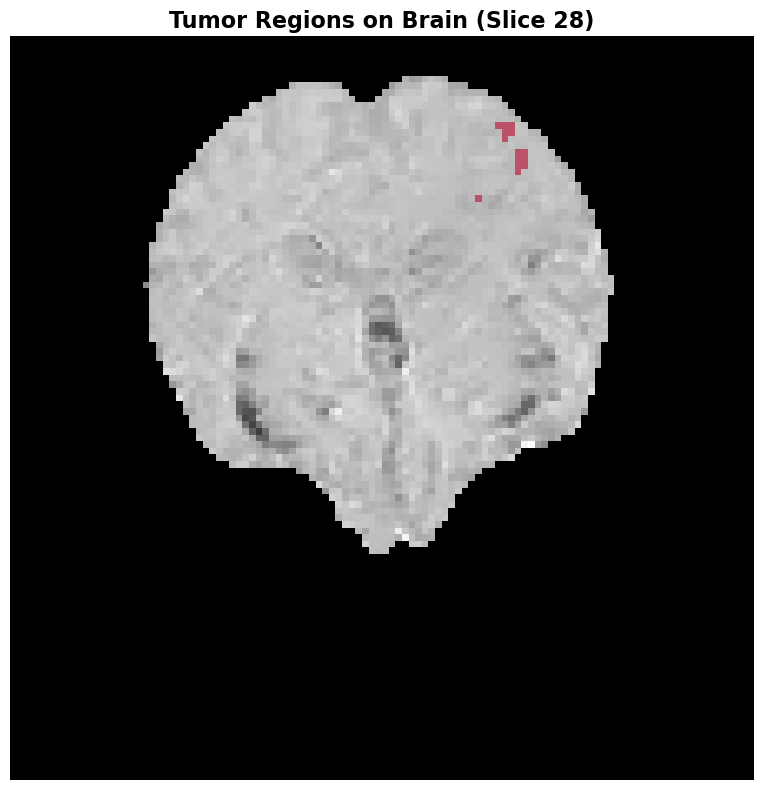

In [6]:
# 1. TUMOR LOCATION OVERLAY ON BRAIN
print("Tumor Location Overlay Visualization")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
brain_slice_28 = data[:, :, 28, 0].T  # b=0 image, transposed
ax.imshow(brain_slice_28, cmap='gray', aspect='equal')

# Overlay tumor regions with inferno colors
for i, (tumor_name, roi_mask) in enumerate(tumor_regions.items()):
    tumor_slice = roi_mask[:, :, 28].T  # Transpose tumor slice
    if np.any(tumor_slice):
        tumor_overlay = np.ma.masked_where(~tumor_slice, tumor_slice)
        ax.imshow(tumor_overlay, cmap='inferno', alpha=0.8, aspect='equal', vmin=0, vmax=2)

ax.set_title('Tumor Regions on Brain (Slice 28)', fontsize=16, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

 DWI Signal Profiles in Tumor Regions


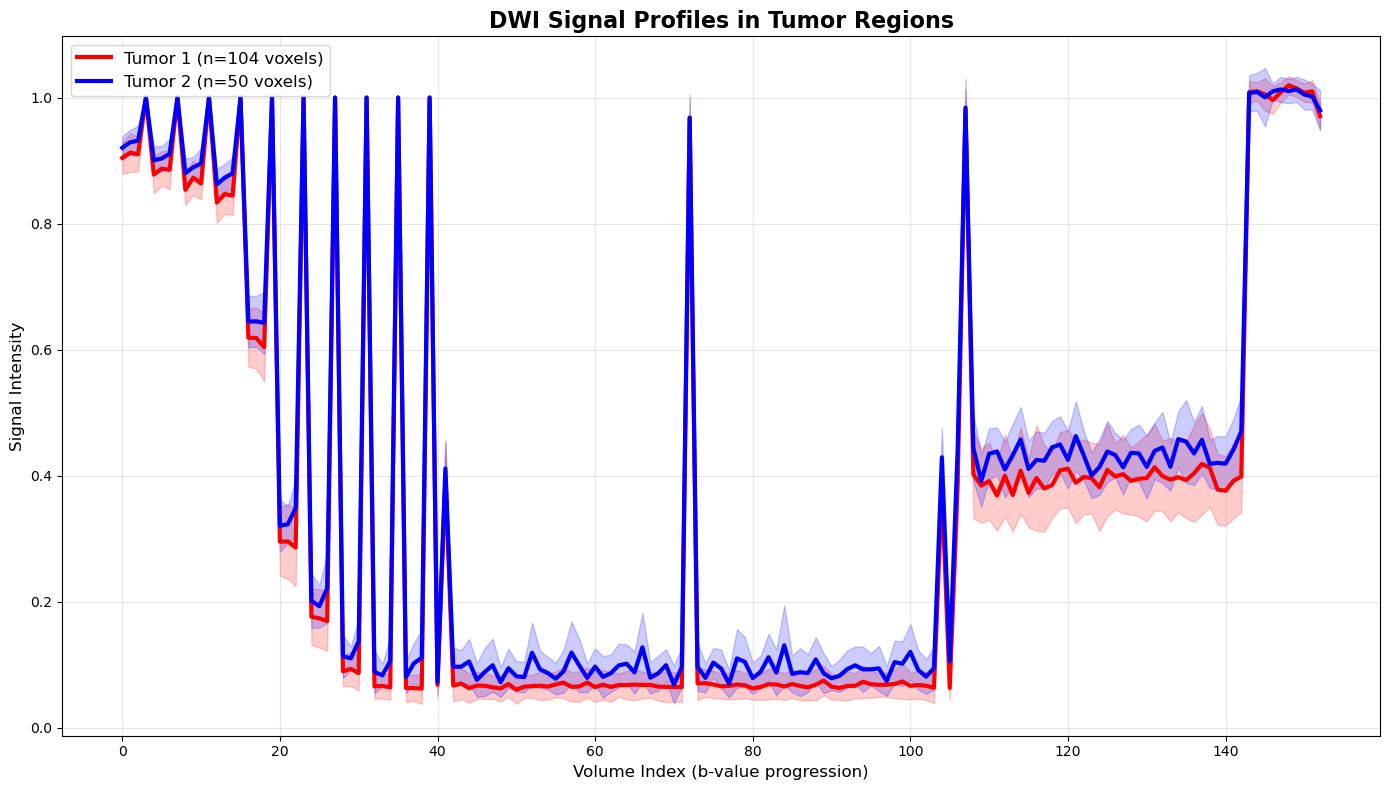

In [7]:
# 4. SIGNAL PROFILES COMPARISON
print(" DWI Signal Profiles in Tumor Regions")

fig, ax = plt.subplots(1, 1, figsize=(14, 8))

for i, (tumor_name, tumor_signal) in enumerate(tumor_signals.items()):
    mean_signal = tumor_signal.mean(axis=0)
    std_signal = tumor_signal.std(axis=0)
    volumes = np.arange(len(mean_signal))
    
    color = ['red', 'blue'][i]
    ax.plot(volumes, mean_signal, color=color, linewidth=3, 
            label=f'{tumor_name.replace("_", " ")} (n={tumor_signal.shape[0]} voxels)')
    ax.fill_between(volumes, mean_signal - std_signal, mean_signal + std_signal, 
                    color=color, alpha=0.2)

ax.set_xlabel('Volume Index (b-value progression)', fontsize=12)
ax.set_ylabel('Signal Intensity', fontsize=12)
ax.set_title('DWI Signal Profiles in Tumor Regions', fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Clinical Tumor Assessment Summary


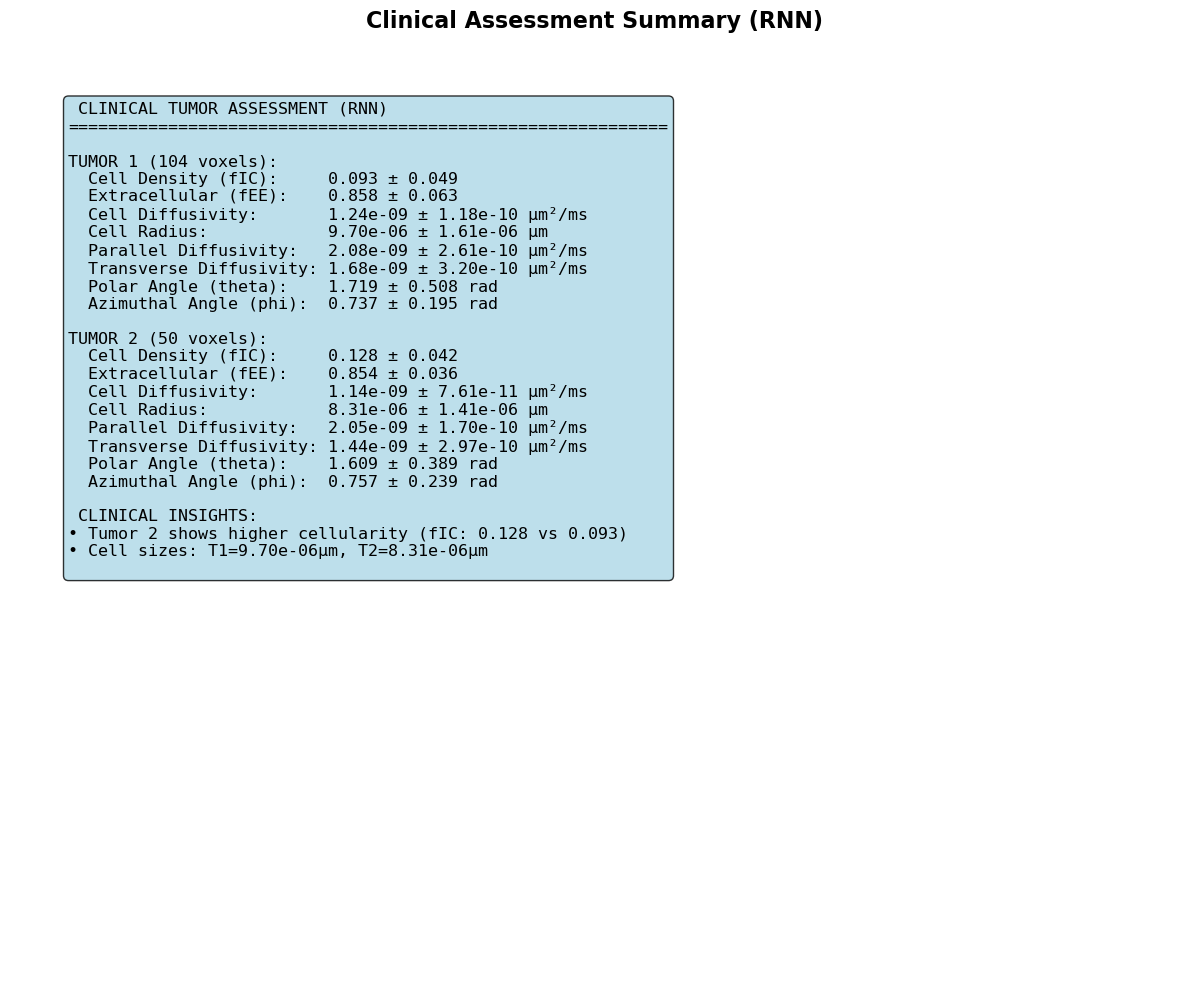

In [10]:
# 5. CLINICAL PARAMETER SUMMARY
print("Clinical Tumor Assessment Summary")

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.axis('off')

# Create summary text
summary_text = " CLINICAL TUMOR ASSESSMENT (RNN)\n" + "="*60 + "\n\n"

tumor_names = list(tumor_verdict_params.keys())
for tumor_name in tumor_names:
    roi_num = tumor_name.split('_')[1]
    stats = tumor_stats[tumor_name]
    
    summary_text += f"TUMOR {roi_num} ({tumor_verdict_params[tumor_name].shape[0]} voxels):\n"
    summary_text += f"  Cell Density (fIC):     {stats['fic']['mean']:.3f} ± {stats['fic']['std']:.3f}\n"
    summary_text += f"  Extracellular (fEE):    {stats['fee']['mean']:.3f} ± {stats['fee']['std']:.3f}\n"
    summary_text += f"  Cell Diffusivity:       {stats['Dic']['mean']:.2e} ± {stats['Dic']['std']:.2e} μm²/ms\n"
    summary_text += f"  Cell Radius:            {stats['R']['mean']:.2e} ± {stats['R']['std']:.2e} μm\n"
    summary_text += f"  Parallel Diffusivity:   {stats['Dpar']['mean']:.2e} ± {stats['Dpar']['std']:.2e} μm²/ms\n"
    summary_text += f"  Transverse Diffusivity: {stats['Dtra']['mean']:.2e} ± {stats['Dtra']['std']:.2e} μm²/ms\n"
    summary_text += f"  Polar Angle (theta):    {stats['theta']['mean']:.3f} ± {stats['theta']['std']:.3f} rad\n"
    summary_text += f"  Azimuthal Angle (phi):  {stats['phi']['mean']:.3f} ± {stats['phi']['std']:.3f} rad\n\n"

# Add clinical interpretation
summary_text += " CLINICAL INSIGHTS:\n"
tumor1_fic = tumor_stats['Tumor_1']['fic']['mean']
tumor2_fic = tumor_stats['Tumor_2']['fic']['mean']

if tumor1_fic > tumor2_fic:
    summary_text += f"• Tumor 1 shows higher cellularity (fIC: {tumor1_fic:.3f} vs {tumor2_fic:.3f})\n"
else:
    summary_text += f"• Tumor 2 shows higher cellularity (fIC: {tumor2_fic:.3f} vs {tumor1_fic:.3f})\n"

summary_text += f"• Cell sizes: T1={tumor_stats['Tumor_1']['R']['mean']:.2e}μm, T2={tumor_stats['Tumor_2']['R']['mean']:.2e}μm\n"


ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.title('Clinical Assessment Summary (RNN)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [ ]:
# BRAIN IMAGES WITH TUMOR REGION MARKINGS
print("\n🧠 BRAIN VISUALIZATION WITH TUMOR REGION MARKERS")
print("=" * 60)

# Import additional libraries for enhanced visualization
from scipy import ndimage
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as patches

# First, let's check which slices actually contain tumor regions
print("Checking tumor presence across slices...")
slice_tumor_info = {}
for slice_idx in [30]:  # Only check slice 30
    slice_tumor_info[slice_idx] = {}
    for tumor_name, roi_mask in tumor_regions.items():
        tumor_slice = roi_mask[:, :, slice_idx]
        tumor_count = np.sum(tumor_slice)
        slice_tumor_info[slice_idx][tumor_name] = tumor_count
        print(f"Slice {slice_idx}, {tumor_name}: {tumor_count} voxels")

# Create comprehensive brain visualization with tumor markings
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
fig.suptitle('Patient08 Brain with Tumor Region Markings - Slice 30', fontsize=18, fontweight='bold', y=0.95)

# Define slice to show
slice_idx = 30  # Only slice 30

# Custom colormap for better tumor visualization
tumor_colors = ['#000000', '#FF6B35', '#F7931E']  # Black, Orange-Red, Yellow-Orange
tumor_cmap = ListedColormap(tumor_colors)

# Brain with enhanced tumor overlay
# Show brain slice with enhanced contrast
brain_slice = data[:, :, slice_idx, 0].T  # b=0 image, transposed

# Enhance brain contrast using histogram equalization
brain_normalized = (brain_slice - brain_slice.min()) / (brain_slice.max() - brain_slice.min())
brain_enhanced = np.power(brain_normalized, 0.7)  # Gamma correction for better contrast

ax.imshow(brain_enhanced, cmap='gray', aspect='equal', alpha=0.95, vmin=0, vmax=1)

# Create combined tumor mask for this slice
combined_tumor_mask = np.zeros_like(brain_slice)
tumor_boundaries = np.zeros_like(brain_slice)

# Process all tumor regions for this slice
for tumor_name, roi_mask in tumor_regions.items():
    tumor_slice = roi_mask[:, :, slice_idx].T
    tumor_num = int(tumor_name.split('_')[1])
    
    # Check if tumor exists in this slice
    if np.any(tumor_slice):
        print(f"  Slice {slice_idx}: Found {tumor_name} with {np.sum(tumor_slice)} voxels")
        combined_tumor_mask[tumor_slice] = tumor_num
        
        # Create enhanced tumor boundaries
        dilated = ndimage.binary_dilation(tumor_slice, structure=np.ones((3,3)))
        eroded = ndimage.binary_erosion(tumor_slice, structure=np.ones((2,2)))
        boundary = dilated & ~eroded
        tumor_boundaries[boundary] = tumor_num
    else:
        print(f"  Slice {slice_idx}: No {tumor_name} found")

# Display tumor regions with custom colormap
if np.any(combined_tumor_mask > 0):
    tumor_overlay = np.ma.masked_where(combined_tumor_mask == 0, combined_tumor_mask)
    ax.imshow(tumor_overlay, cmap=tumor_cmap, alpha=0.7, aspect='equal', vmin=0, vmax=2)

# Display tumor boundaries with high contrast
if np.any(tumor_boundaries > 0):
    boundary_overlay = np.ma.masked_where(tumor_boundaries == 0, tumor_boundaries)
    ax.imshow(boundary_overlay, cmap='plasma', alpha=0.9, aspect='equal', vmin=0, vmax=2)

# Add tumor labels with improved positioning for all tumors
labels_added = []
for tumor_name, roi_mask in tumor_regions.items():
    tumor_slice = roi_mask[:, :, slice_idx].T
    tumor_num = int(tumor_name.split('_')[1])
    
    if np.any(tumor_slice):
        coords = np.where(tumor_slice)
        if len(coords[0]) > 0:
            centroid_y, centroid_x = coords[0].mean(), coords[1].mean()
            
            # Adjust label positions to avoid overlap
            if tumor_num == 1:
                offset_x, offset_y = 20, -20
            else:  # tumor_num == 2
                offset_x, offset_y = -20, 20
            
            # Add arrow pointing to tumor center
            ax.annotate(f'Tumor {tumor_num}', 
                       xy=(centroid_x, centroid_y),
                       xytext=(centroid_x + offset_x, centroid_y + offset_y),
                       arrowprops=dict(arrowstyle='->', color='cyan', lw=3, 
                                     connectionstyle=f"arc3,rad={0.2 if tumor_num==1 else -0.2}"),
                       fontsize=11, fontweight='bold', color='white',
                       bbox=dict(boxstyle='round,pad=0.4', 
                               facecolor=['navy', 'darkgreen'][tumor_num-1], 
                               alpha=0.8, edgecolor='cyan', linewidth=2))
            labels_added.append(tumor_num)
    else:
        # Add text note for missing tumors
        ax.text(0.02, 0.98 - 0.05*tumor_num, f'Tumor {tumor_num}: Not present in this slice', 
               transform=ax.transAxes, fontsize=9, color='yellow',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

ax.set_title(f'Brain + Tumors (Slice {slice_idx})', fontsize=13, fontweight='bold', pad=15)
ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Adjust to prevent title overlap
plt.show()

# Create a detailed single-slice view with enhanced tumor marking
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Tumor Region Analysis - Slice 28', fontsize=18, fontweight='bold', y=0.95)

main_slice = 28

# 1. Original brain image with enhanced contrast
ax = axes[0]
brain_slice = data[:, :, main_slice, 0].T

# Apply contrast enhancement
brain_normalized = (brain_slice - brain_slice.min()) / (brain_slice.max() - brain_slice.min())
brain_enhanced = np.power(brain_normalized, 0.6)  # Gamma correction

im1 = ax.imshow(brain_enhanced, cmap='gray', aspect='equal', vmin=0, vmax=1)
ax.set_title('Enhanced Brain Image (b=0)', fontsize=14, fontweight='bold')
ax.axis('off')

# Add scale bar
scale_bar = patches.Rectangle((brain_enhanced.shape[1]-20, brain_enhanced.shape[0]-5), 
                             15, 2, linewidth=0, facecolor='white')
ax.add_patch(scale_bar)
ax.text(brain_enhanced.shape[1]-12, brain_enhanced.shape[0]-8, '15 voxels', 
        color='white', fontsize=10, ha='center', fontweight='bold')

cbar1 = plt.colorbar(im1, ax=ax, shrink=0.8, label='Normalized Signal Intensity')

# 2. Brain with enhanced tumor overlay and professional markers
ax = axes[1]
ax.imshow(brain_enhanced, cmap='gray', aspect='equal', alpha=0.85, vmin=0, vmax=1)

# Create professional tumor visualization
tumor_colors_detailed = ['#000000', '#FF4444', '#FFAA00']  # Black, Bright Red, Bright Orange
tumor_cmap_detailed = ListedColormap(tumor_colors_detailed)

# Combine all tumors for this slice
combined_tumor = np.zeros_like(brain_slice)
tumor_info = {}

for tumor_name, roi_mask in tumor_regions.items():
    tumor_slice = roi_mask[:, :, main_slice].T
    if np.any(tumor_slice):
        tumor_num = int(tumor_name.split('_')[1])
        combined_tumor[tumor_slice] = tumor_num
        
        # Store tumor info
        coords = np.where(tumor_slice)
        tumor_info[tumor_num] = {
            'centroid': (coords[0].mean(), coords[1].mean()),
            'voxels': len(coords[0]),
            'bounds': (coords[0].min(), coords[0].max(), coords[1].min(), coords[1].max())
        }
        
        # Create enhanced tumor boundaries
        dilated = ndimage.binary_dilation(tumor_slice, structure=np.ones((4,4)))
        eroded = ndimage.binary_erosion(tumor_slice, structure=np.ones((2,2)))
        thick_boundary = dilated & ~eroded
        
        # Display thick boundaries first
        if np.any(thick_boundary):
            boundary_mask = np.ma.masked_where(~thick_boundary, thick_boundary)
            ax.imshow(boundary_mask, cmap='plasma', alpha=0.9, aspect='equal', vmin=0, vmax=1)

# Display tumor regions with enhanced visibility
if np.any(combined_tumor > 0):
    tumor_overlay = np.ma.masked_where(combined_tumor == 0, combined_tumor)
    ax.imshow(tumor_overlay, cmap=tumor_cmap_detailed, alpha=0.8, aspect='equal', vmin=0, vmax=2)

# Add professional tumor annotations
for tumor_num, info in tumor_info.items():
    centroid_y, centroid_x = info['centroid']
    voxel_count = info['voxels']
    
    # Position labels to avoid overlap
    offset_x = 25 if tumor_num == 1 else -25
    offset_y = -25 if tumor_num == 1 else 25
    
    # Create professional annotation with leader lines
    ax.annotate(f'Tumor Region {tumor_num}\n{voxel_count} voxels\n({voxel_count:.1f} mm³)', 
               xy=(centroid_x, centroid_y),
               xytext=(centroid_x + offset_x, centroid_y + offset_y),
               arrowprops=dict(arrowstyle='->', color='cyan', lw=3, 
                             connectionstyle="arc3,rad=0.3"),
               fontsize=11, fontweight='bold', color='white',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='darkblue', 
                        alpha=0.9, edgecolor='cyan', linewidth=2))
    
    # Add crosshair at tumor center
    ax.plot([centroid_x-3, centroid_x+3], [centroid_y, centroid_y], 
           color='yellow', linewidth=2, alpha=0.8)
    ax.plot([centroid_x, centroid_x], [centroid_y-3, centroid_y+3], 
           color='yellow', linewidth=2, alpha=0.8)

ax.set_title('Brain with Professional Tumor Markers', fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Prevent title overlap
plt.show()

# Create tumor statistics summary
print("\n📊 TUMOR REGION SUMMARY:")
print("-" * 50)
total_tumor_voxels = 0
for tumor_name, roi_mask in tumor_regions.items():
    tumor_num = tumor_name.split('_')[1]
    voxel_count = np.sum(roi_mask)
    total_tumor_voxels += voxel_count
    
    # Calculate tumor volume (assuming 1mm³ per voxel)
    tumor_volume_mm3 = voxel_count  # 1 voxel = 1 mm³
    
    print(f"🔴 Tumor {tumor_num}:")
    print(f"   Voxels: {voxel_count}")
    print(f"   Volume: ~{tumor_volume_mm3:.1f} mm³")
    
    # Get tumor location info
    coords = np.where(roi_mask)
    if len(coords[0]) > 0:
        centroid = (coords[0].mean(), coords[1].mean(), coords[2].mean())
        print(f"   3D Centroid: ({centroid[0]:.1f}, {centroid[1]:.1f}, {centroid[2]:.1f})")
        print(f"   Z-range: {coords[2].min()} - {coords[2].max()} (slices)")
    print()

print(f"📈 TOTAL TUMOR BURDEN:")
print(f"   Combined voxels: {total_tumor_voxels}")
print(f"   Combined volume: ~{total_tumor_voxels:.1f} mm³")
brain_voxels = np.sum(np.any(data > 0, axis=3))
tumor_percentage = (total_tumor_voxels / brain_voxels) * 100
print(f"   % of brain tissue: {tumor_percentage:.3f}%")
print("-" * 50)